# **CA 2, LLMs Spring 2025**

- **Name:OMID**
- **Student ID:!**

---
#### Your submission should be named using the following format: `CA2_LASTNAME_STUDENTID.ipynb`.

---

##### *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says ```Your Answer Here``` with your actual answer.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

If you have any further questions or concerns, contact the TAs via email: m.salmani78@ut.ac.ir / mehrabi.m@ut.ac.ir

## Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [9]:
#!pip install bitsandbytes

In [4]:
!pip install datasets Levenshtein
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstall

In [5]:
import torch
import numpy as np
import re
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from Levenshtein import ratio
from collections import defaultdict
from datasets import load_dataset
from trl import ORPOConfig, ORPOTrainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
"token = '[REMOVED]'"

In [7]:
class CONFIG:
    seed = 42
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_name = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"
    reward_model_name = "nicolinho/QRM-Llama3.1-8B-v2"
    benchmark_name = "openai/gsm8k"
    dataset_name = "mlabonne/orpo-dpo-mix-40k"

    train_data_size = 1600
    benchmark_subset_size = 50
    max_seq_length = 1024
    train_batch_size = 2
    gradient_accumulation_steps = 4
    epochs = 1

    # LoRA Configs
    lora_rank = 64
    lora_alpha = 64
    use_gradient_checkpointing = "unsloth"
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],

    dpo_output_dir = "llama-3.2-3b-dpo-checkpoint"
    orpo_output_dir = "llama-3.2-3b-orpo-checkpoint"

device = CONFIG.device

### Introductions to unsloth

Modern large language models (LLMs) require significant computational resources for fine-tuning and inference. The `unsloth` library is designed to optimize these processes by making training up to 30× faster and reducing memory usage by 60%, enabling more efficient model adaptation on consumer-grade GPUs.

---

**Learn More:**

<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

### Install and Setup

In [8]:
%%capture
import os
!pip install datasets
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
    !pip install --no-deps cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [9]:
import unsloth
print(unsloth.__version__)

2025.3.19


# In-context Learning (30 Points)

### Question 1 (5 points):

**a)** What is In-Context Learning (ICL), and how does it differ from fine-tuning? What are its limitations compared to fine-tuning?

**b)** Explain what [Chain-of-Thought (CoT)](https://arxiv.org/abs/2201.11903) prompting is and how it works.

a) In-Context Learning (ICL) is a method where large language models learn to perform tasks by seeing examples in the input prompt, without any change to the model’s parameters. It differs from fine-tuning in that fine-tuning involves updating the model's internal weights using a labeled dataset to permanently improve performance on specific tasks. ICL is faster and requires fewer resources because it avoids retraining, but it has limitations: it relies on temporary memory (only during inference), is constrained by the maximum input length (token limit), and is generally less accurate or robust for complex or specialized tasks compared to fine-tuned models. Fine-tuning allows for deeper, lasting adaptation, while ICL is more like “on-the-fly” learning.

b) Chain-of-Thought (CoT) prompting is a technique used to improve the reasoning abilities of language models by encouraging them to generate intermediate steps when solving a problem. Instead of asking the model to directly produce an answer, CoT prompting provides examples where problems are solved step-by-step, guiding the model to mimic that reasoning pattern. This approach helps especially in multi-step problems like math, logic, or commonsense reasoning, as it allows the model to “think out loud” before reaching the final answer. CoT is particularly effective in large models and often leads to more accurate and explainable responses.

### Load Model & Tokenizer (2.5 points)

- Load `Llama-3.2-3B-Instruct-bnb-4bit` model using `unsloth` for inference.

In [10]:
from unsloth import FastLanguageModel

def load_model_and_tokenizer(model_id, max_seq_length):
    print("Loading model and tokenizer using unsloth...")
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = model_id,
        max_seq_length = max_seq_length,
        dtype = None,
        load_in_4bit = True,
    )
    return model, tokenizer

In [11]:
model, tokenizer = load_model_and_tokenizer(CONFIG.model_name, CONFIG.max_seq_length)

Loading model and tokenizer using unsloth...
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

### Load benchmark (2.5 points)

1. Load the `GSM8K` benchmark dataset.
2. Randomly select a subset of `50` samples from the dataset.
3. Display one sample from the selected subset.
<a id="gsm8k_benchmark"></a>

In [12]:
import random

def load_gsm8k_dataset():
    """Load the GSM8K dataset from HuggingFace."""
    dataset = load_dataset("gsm8k", "main")
    return dataset

def create_sample_dataset(dataset, num_samples, seed):
    """Create a fixed sample dataset for evaluation."""
    sample_test = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    return sample_test

In [13]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load dataset
dataset = load_gsm8k_dataset()

# Select subset
sample_dataset = create_sample_dataset(dataset, num_samples=CONFIG.benchmark_subset_size, seed=CONFIG.seed)


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [14]:
# Display one sample
print(sample_dataset[0])

{'question': 'Mimi picked up 2 dozen seashells on the beach.  Kyle found twice as many shells as Mimi and put them in his pocket. Leigh grabbed one-third of the shells that Kyle found.  How many seashells did Leigh have?', 'answer': 'Mimi has 2 x 12 = <<2*12=24>>24 sea shells.\nKyle has 24 x 2 = <<24*2=48>>48 sea shells.\nLeigh has 48 / 3 = <<48/3=16>>16 sea shells.\n#### 16'}


### Prompt Engineering (10 points)

Implement different prompting strategies for in-context learning.
At least four of the following methods should be implemented (including baseline):
- Zero-shot (**Baseline**)
- Role-play prompting [[paper](https://aclanthology.org/2024.naacl-long.228/)]
- Zero-shot CoT [[paper](https://arxiv.org/abs/2205.11916)]
- Few-shot CoT
- Least-to-Most prompting [[paper](https://arxiv.org/abs/2205.10625)]
- Generated Knowledge prompting [[paper](https://aclanthology.org/2022.acl-long.225/)]
- Any other idea to improve performance (**Optional**)

Additionally, if performance exceeds 80%, **two extra points** are awarded for every 5% improvement. You can try other methods or a combination of existing ones.

<a id="prompt-engineering"></a>

In [30]:
def create_prompts(question, examples=None):
    """
    Build multiple chat-style prompts aligned with medium-to-advanced multi-step word problems.
    Answer format is simplified as: [ANSWER]: <final number>
    """
    prompts = {}
    final_format_instruction = "Return only the final numeric answer using this format:\n[ANSWER]: <your final answer>"

    DEFAULT_FEW_SHOT_EXAMPLES = [
        {
            "question": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?",
            "answer": "Natalia sold 48 clips in April. In May, she sold half as many clips as in April, so she sold 48 / 2 = 24 clips. Altogether, Natalia sold 48 + 24 = 72 clips.\n[ANSWER]: 72"
        },
        {
            "question": "Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?",
            "answer": "Weng earns $12 an hour, which is $12 / 60 minutes = $0.20 per minute. Since she babysat for 50 minutes, she earned 50 * $0.20 = $10.\n[ANSWER]: 10"
        },
        {
            "question": "Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?",
            "answer": "The wallet costs $100. Betty has half the money, so she has $100 / 2 = $50. Her parents give her $15. Her grandparents give her twice as much as her parents, so they give her 2 * $15 = $30. In total, Betty has $50 + $15 + $30 = $95. She needs $100 to buy the wallet, so she needs $100 - $95 = $5 more.\n[ANSWER]: 5"
        }
    ]

    if examples is None:
        examples = DEFAULT_FEW_SHOT_EXAMPLES

    # Baseline
    prompts["Baseline"] = [
        {"role": "system", "content": "You are a math assistant that only provides final numeric answers."},
        {"role": "user", "content": (
            f"Problem: {question}\n\n"
            f"Please output only the final numeric result in the following format:\n[ANSWER]: <your final answer>"
        )}
    ]

    # Role-Prompting
    prompts["Role-Prompting"] = [
        {"role": "system", "content": "You are a brilliant mathematician who solves problems step-by-step with clear logic."},
        {"role": "user", "content": (
            f"Problem: {question}\n"
            "Think through the steps carefully. Then return only the final numeric answer.\n"
            f"{final_format_instruction}"
        )}
    ]

    # Zero-shot CoT
    prompts["Zero-shot CoT"] = [
        {"role": "system", "content": "You are a math tutor who solves problems step-by-step."},
        {"role": "user", "content": (
            f"Problem: {question}\nLet's think step-by-step.\n\n{final_format_instruction}"
        )}
    ]

    # Few-shot CoT
    few_shot_cot_prompt = [{"role": "system", "content": "You are a helpful math tutor. Think step-by-step and return only the final number in the format: [ANSWER]: <your final answer>"}]

    for ex in examples:
        few_shot_cot_prompt.append({"role": "user", "content": f"Problem: {ex['question']}\nLet's think step-by-step."})
        few_shot_cot_prompt.append({"role": "assistant", "content": ex['answer']})

    few_shot_cot_prompt.append({"role": "user", "content": f"Problem: {question}\nLet's think step-by-step.\n{final_format_instruction}"})
    prompts["Few-shot CoT"] = few_shot_cot_prompt

    # Least-to-Most
    prompts["Least-to-Most"] = [
        {"role": "system", "content": "You solve complex problems by breaking them into smaller parts and combining results."},
        {"role": "user", "content": (
            f"Q: {question}\nThis problem seems tricky.\n"
            "Step 1: Understand the goal.\n"
            "Step 2: Solve each part.\n"
            "Step 3: Combine all to get the final answer.\n\n"
            f"{final_format_instruction}"
        )}
    ]

    # Generated Knowledge
    prompts["Generated Knowledge"] = [
        {"role": "system", "content": "You are a math solver who uses known formulas and concepts to solve real-world problems."},
        {"role": "user", "content": (
            f"Q: {question}\nUseful concepts: percent = part/whole * 100, average = total / count, profit = revenue - cost.\n"
            "Apply the needed concepts and solve step-by-step.\n\n"
            f"{final_format_instruction}"
        )}
    ]

    return prompts

### Evaluate Prompting Strategies (10 points)

1. Implement an evaluation function to assess different prompts.
2. Compare the accuracy of various prompting methods.
3. Visualize results and show some sample responses.

In [31]:
import re

def extract_answer(text):
    """
    Extract the final numerical answer from the model output.
    1. Prefer numbers in the format \boxed{...}, including negative and decimal numbers.
    2. If not found, fallback to the last standalone number (int or float) in the text.
    """
    match = re.search(r"\\boxed\{([-+]?\d*\.?\d+)\}", text)
    if match:
        return float(match.group(1))

    numbers = re.findall(r"[-+]?\d*\.?\d+", text)
    if numbers:
        return float(numbers[-1])

    return None


In [32]:
from unsloth.chat_templates import get_chat_template
from tqdm import tqdm
import torch

def evaluate_prompts(model, tokenizer, sample_dataset, seed=42, temperature=0.1, top_p=0.9):
    """
    Evaluates different chat-style prompt types using a compatible chat-template structure.
    """

    # استفاده از تابع درست
    prompt_types = list(create_prompts("dummy").keys())
    model_ans = {k: [] for k in prompt_types}
    all_samples = []

    # استخراج پاسخ واقعی
    true_ans = [extract_answer(sample["answer"]) for sample in sample_dataset]

    # آماده‌سازی قالب چت و مدل
    tokenizer = get_chat_template(tokenizer, chat_template="llama-3.2")
    model = FastLanguageModel.for_inference(model)

    for i, sample in enumerate(tqdm(sample_dataset)):
        question = sample["question"]
        correct_answer = true_ans[i]
        prompts = create_prompts(question)  # <- استفاده از تابع درست

        for prompt_type, messages in prompts.items():
            # messages همین حالا لیستی از role-content هست

            # قالب‌سازی با tokenizer و تبدیل به رشته قابل پردازش
            prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

            # توکن‌سازی و inference
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            outputs = model.generate(**inputs, max_new_tokens=200, temperature=temperature, top_p=top_p)
            decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

            predicted_answer = extract_answer(decoded)

            model_ans[prompt_type].append(predicted_answer)
            all_samples.append({
                "question": question,
                "prompt_type": prompt_type,
                "prompt_text": prompt,
                "true_answer": correct_answer,
                "predicted_answer": predicted_answer,
                "is_correct": (
                    predicted_answer is not None and
                    correct_answer is not None and
                    int(float(predicted_answer)) == int(float(correct_answer))
                ),
                "decoded_output": decoded
            })

    # محاسبه دقت برای هر پرامپت
    correct = {k: 0 for k in prompt_types}
    accuracy = {k: 0 for k in prompt_types}
    for prompt_type in prompt_types:
        for pred, true in zip(model_ans[prompt_type], true_ans):
            if pred is not None and true is not None:
                if int(float(pred)) == int(float(true)):
                    correct[prompt_type] += 1
        accuracy[prompt_type] = correct[prompt_type] / len(true_ans)

    return accuracy, all_samples


In [22]:
import json
import pandas as pd

def save_results(accuracy, all_samples, base_path="/content/drive/MyDrive/Colab Notebooks/CA2/"):
    """Save accuracy (as JSON) and all_samples (as CSV and JSON) to Google Drive."""

    # ذخیره accuracy به JSON
    acc_path = base_path + "accuracy.json"
    with open(acc_path, "w", encoding="utf-8") as f:
        json.dump(accuracy, f, indent=2)

    # ذخیره all_samples به CSV
    samples_df = pd.DataFrame(all_samples)
    samples_df.to_csv(base_path + "all_samples.csv", index=False)

    # ذخیره all_samples به JSON (اختیاری)
    with open(base_path + "all_samples.json", "w", encoding="utf-8") as f:
        json.dump(all_samples, f, indent=2)

    print(f"✔️ Results saved to:\n- {acc_path}\n- all_samples.csv\n- all_samples.json")


In [ ]:
# def load_results(base_path="/content/drive/MyDrive/Colab Notebooks/CA2/"):
#     """Load accuracy and all_samples from previously saved files."""
#     # بارگذاری accuracy از JSON
#     with open(base_path + "accuracy.json", "r", encoding="utf-8") as f:
#         accuracy = json.load(f)

#     # بارگذاری all_samples از CSV
#     df = pd.read_csv(base_path + "all_samples.csv")
#     all_samples = df.to_dict(orient="records")

#     print("✔️ Results loaded successfully.")
#     return accuracy, all_samples

In [33]:
print("Accuracy by prompting method:")
accuracy, all_samples = evaluate_prompts(model, tokenizer, sample_dataset)

for prompt_type, acc in accuracy.items():
    print(f"{prompt_type}: {acc:.2%}")

Accuracy by prompting method:


100%|██████████| 50/50 [24:09<00:00, 28.99s/it]

Baseline: 12.00%
Role-Prompting: 82.00%
Zero-shot CoT: 60.00%
Few-shot CoT: 82.00%
Least-to-Most: 62.00%
Generated Knowledge: 70.00%


In [24]:
import os
import json
import pandas as pd

def save_results(accuracy, all_samples, base_path="./outputs/"):
    """
    Save accuracy (as JSON) and all_samples (as CSV and JSON) to a local folder (Kaggle-compatible).
    """
    # ساخت مسیر اگر وجود نداشت
    os.makedirs(base_path, exist_ok=True)

    # ذخیره accuracy به JSON
    acc_path = os.path.join(base_path, "accuracy.json")
    with open(acc_path, "w", encoding="utf-8") as f:
        json.dump(accuracy, f, indent=2)

    # ذخیره all_samples به CSV
    samples_df = pd.DataFrame(all_samples)
    samples_df.to_csv(os.path.join(base_path, "all_samples.csv"), index=False)

    # ذخیره all_samples به JSON
    with open(os.path.join(base_path, "all_samples.json"), "w", encoding="utf-8") as f:
        json.dump(all_samples, f, indent=2)

    print(f"✔️ Results saved to:\n- {acc_path}\n- all_samples.csv\n- all_samples.json")

# حالا می‌تونی راحت صدا بزنی:
save_results(accuracy, all_samples)


✔️ Results saved to:
- ./outputs/accuracy.json
- all_samples.csv
- all_samples.json


In [23]:
save_results(accuracy, all_samples)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/CA2/accuracy.json'

In [29]:
def visualize_results(model_name, accuracies):
    """Create a bar chart of prompt method accuracies."""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
    plt.title(f"Accuracy by Prompting Method ({model_name})")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis="y")

    return plt

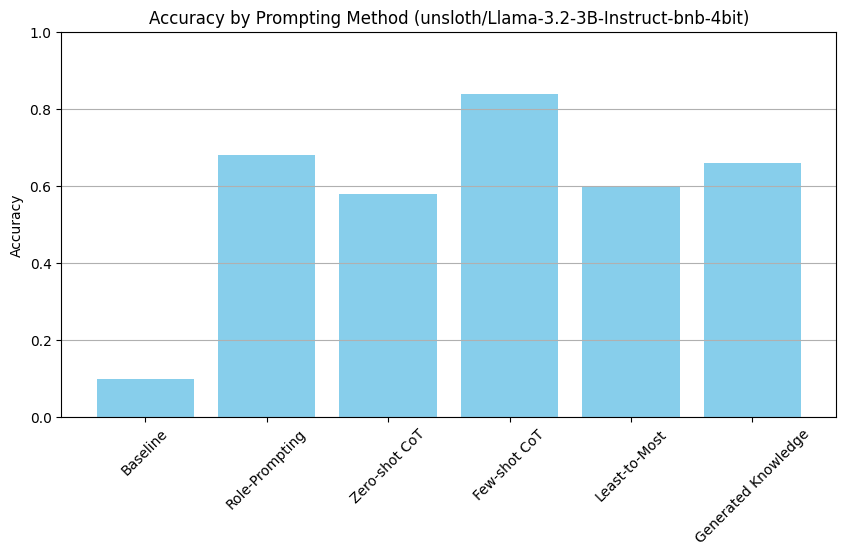

In [20]:
plt = visualize_results(CONFIG.model_name, accuracy)
plt.show()

# Human Preference Alignment (80 Points)

## RLHF Flow

<img src="https://huyenchip.com/assets/pics/rlhf/6-sft-rlhf.png" width="80%">

With the rise of **ChatGPT**, **Reinforcement Learning from Human Feedback (RLHF)** has gained significant attention in both academic and industrial language modeling communities.

The approach dates back to **OpenAI’s 2019 paper**:  
[Fine-Tuning Language Models from Human Preferences](https://arxiv.org/abs/1909.08593).  

A year later, OpenAI demonstrated RLHF’s effectiveness in **natural language generation**:  
[Learning to Summarize from Human Feedback](https://arxiv.org/abs/2009.01325).  

This research showed that fine-tuning alone leads to **suboptimal human-aligned performance**. RLHF optimizes models using human feedback, significantly improving their output quality.


## Reward Models (20 Points)

### Question 2 (5 points):
<img width="50%" alt="image" src="https://github.com/RLHFlow/RLHFlow.github.io/blob/main/assets/BT-and-Pref-RMs.png?raw=true">

In Reinforcement Learning from Human Feedback (RLHF), the reward model is essential for aligning large language models with human preferences. A widely used method, based on the **Bradley-Terry** model, trains the reward model using the following pairwise ranking loss function for a prompt and two responses (<font color='green'><b>chosen</b></font> and <font color='red'><b>rejected</b></font>):

$$
\text{loss}(r_{\theta}) = -\mathbb{E}_{(x, y_0, y_1, i) \sim D} \left[ \log \left( \sigma \left( r_{\theta}(x, y_i) - r_{\theta}(x, y_{1-i}) \right) \right) \right]
$$

where:
- $x$ is the prompt,
- $y_0$ and $y_1$ are two responses,
- $i$ (0 or 1) indicates the human-preferred response,
- $r_{\theta}(x, y)$ is the reward model’s scalar value for the prompt $ x $ and the response $ y $,
- $\sigma$ is the sigmoid function.

**a)** How this loss function encourages higher scores for preferred responses.

**b)** Discuss one potential limitation of this approach, such as reward hacking (e.g., favoring longer responses), and suggest a general strategy to mitigate it.

### ✅ (a) How this loss function encourages higher scores for preferred responses

The loss function is defined as:

$$
\mathcal{L}(r_\theta) = -\mathbb{E}_{(x, y_0, y_1, i) \sim \mathcal{D}} \left[ \log\left( \sigma\left(r_\theta(x, y_i) - r_\theta(x, y_{1-i})\right) \right) \right]
$$

Here, $i$ indicates the human-preferred response among $y_0$ and $y_1$.

This function encourages the reward model $r_\theta$ to assign higher scores to the preferred response $y_i$ compared to the rejected response $y_{1-i}$. When the score difference $r_\theta(x, y_i) - r_\theta(x, y_{1-i})$ increases, the sigmoid function $\sigma(\cdot)$ approaches 1, making the log term $\log(\sigma(\cdot))$ closer to 0. Since the loss is negative log-likelihood, minimizing the loss requires maximizing this probability.

**Conclusion:**  
Minimizing $\mathcal{L}$ directly incentivizes the model to increase the score of the preferred response relative to the rejected one, aligning model outputs with human preferences.

### ⚠️ (b) One limitation (e.g., reward hacking) and mitigation strategy

A major limitation of this approach is the risk of **reward hacking**, where the model exploits flaws in the reward signal instead of producing genuinely better outputs. Examples include:

- Generating overly long responses because they tend to be preferred.
- Using excessive politeness or agreeable phrases to gain better reward scores.
- Mimicking stylistic patterns without actual content improvement.

---

#### 💡 Mitigation Strategies:

1. **Length Penalty (Normalization):**  
   Penalize overly long responses by modifying the reward function:

   $$
   r'(x, y) = r_\theta(x, y) - \lambda \cdot \text{length}(y)
   $$

2. **Multi-objective Rewarding:**  
   Incorporate additional objectives like factual correctness, conciseness, or relevance alongside human preference.

3. **Adversarial Training:**  
   Train the model on counterexamples (e.g., misleading


### Question 3 (5 points):

The Bradley-Terry model is widely used in RLHF to train reward models by converting pairwise human preferences into a single scalar value. However, this approach has limitations when capturing complex human values like helpfulness, honesty, and safety, which may require multiple dimensions.

**a)** Why a single scalar reward might fail to capture trade-offs between objectives like helpfulness and safety, using a concrete example (e.g., a response to a user query).

**b)** Describe one alternative method to the Bradley-Terry model that addresses these limitations, such as by considering multiple objectives, mitigating biases, or improving interpretability. (For inspiration, explore resources like this [repository](https://github.com/RLHFlow/RLHF-Reward-Modeling/) or this [paper](https://arxiv.org/abs/2406.12845)). How does this alternative improve upon the single-scalar approach?

### ✅ (a) Why a single scalar reward might fail to capture trade-offs

The Bradley-Terry model produces a single scalar value $r_\theta(x, y)$ for each prompt-response pair. However, this **scalar reward** may fail to represent nuanced trade-offs between different human values such as:

- **Helpfulness** (Is the response useful and informative?)
- **Safety** (Does it avoid harmful, toxic, or misleading content?)
- **Honesty** (Is the information truthful and based on facts?)

---

#### 🧠 Example:

**Prompt:**  
*"Can I take ibuprofen and alcohol together?"*

**Response A:**  
*"Yes, but only in moderation. It is usually safe if you do not have liver problems."*  
(score: 4.5)

**Response B:**  
*"It is not recommended to combine ibuprofen and alcohol, as it may increase the risk of gastrointestinal bleeding and liver damage."*  
(score: 4.2)

---

While Response A might be more *helpful* or *friendly*, Response B prioritizes *safety*. A scalar reward model must choose only one "better" answer overall, but **cannot express the tension or trade-off** between these dimensions.

So, using only a scalar reward forces a **single-axis optimization**, which can miss the balance required for safe and helpful AI behavior.

---
---
---
### ✅ (b) Alternative to Bradley-Terry – Multi-Objective or Decomposed Reward Models

An effective alternative to the scalar Bradley-Terry reward is using a **Multi-Objective Reward Model** (also known as Decomposed Reward Model), where the model outputs multiple scalar values — one for each human-aligned objective (e.g., helpfulness, safety, honesty).

---

#### 📌 Key Idea:

Instead of:

$$
r_\theta(x, y) \in \mathbb{R}
$$

We model:

$$
\vec{r}_\theta(x, y) = \left[ r^{\text{helpfulness}}_\theta, r^{\text{safety}}_\theta, r^{\text{honesty}}_\theta, \dots \right] \in \mathbb{R}^n
$$

These sub-rewards are then either:

- **Aggregated via a weighted sum**, tuned based on human preference:
  $$
  r_{\text{total}} = \sum_i w_i \cdot r^{(i)}_\theta
  $$
- **Or used independently** for multi-objective optimization (e.g., via Pareto front training, constrained reinforcement learning).

---

#### ✅ Benefits over scalar reward:

- 🌱 **More interpretable**: We know *why* a response is rated high or low (e.g., it was helpful but not safe).
- 🔧 **Tunable**: We can adjust weights to prioritize different values in different contexts (e.g., safety > helpfulness in healthcare).
- 🛡 **Safer**: Allows better handling of trade-offs, reducing reward hacking.
- 🧠 **More human-aligned**: Closer to how humans make judgments based on multiple criteria.

---

#### 📖 Reference:

This idea is discussed in:

- "Decomposed Reward Models for Human Alignment" (OpenAI)  
- Anthropic’s Constitutional AI, which uses rule-based scoring per value dimension  
- [OpenAI/reward-modeling GitHub repo](https://github.com/openai/reward-modeling)

These models show that multiple-objective or interpretable decompositions help in better aligning LLMs with nuanced human preferences.



---

**Find More:**
<br>[RewardBench LeaderBoard](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)

---

### Inference from the Reward Model (10 points)

<div align="center"><img width="90%" alt="image" src="https://github.com/Nicolinho/QRM/blob/main/assets/method_vis.png?raw=true"></div>

**Quantile Reward Models (QRM)** generates a distribution over rewards by aggregating individual distributions over attribute scores like helpfulness and harmlessness.

- Load the [reward model](https://huggingface.co/nicolinho/QRM-Llama3.1-8B-v2) and its tokenization

In [ ]:
# WRITE YOUR CODE HERE

- Generate reward scores for both responses.

In [ ]:
# Prompt and responses
sample_prompt = "Do wooden pencils contain lead as their core?"
chosen_response = "No, wooden pencils do not contain lead in their core. The term \"lead\" is a misnomer, as wooden pencils actually use graphite for their core. Graphite was historically called \"black lead\" due to its appearance, leading to the common misconception that pencils contain lead."
rejected_response = "Yes, wooden pencils typically contain a core made of graphite and clay, which is commonly referred to as \"lead\" despite not being made of actual lead."

# WRITE YOUR CODE HERE

- Visualize the results:

    + Create a bar chart comparing the reward scores of the chosen vs. the rejected response for each attribute.
    + Overlay a line chart representing the gating output coefficients.

In [ ]:
# The attributes of the 5 reward objectives
attributes = ['helpfulness','correctness','coherence', 'complexity','verbosity']

# WRITE YOUR CODE HERE

## PPO (15 Points)

### Question 4 (5 points):
**a)** Describe the Proximal Policy Optimization (PPO) algorithm and explain its role in the Reinforcement Learning from Human Feedback (RLHF) framework.

**b)** Specifically, is PPO an on-policy or off-policy algorithm, and why is this characteristic important for its application in RLHF?

`# WRITE YOUR ANSWER HERE`

### Question 5 (5 points):

**a)** Why is it crucial to prevent drastic changes in the Large Language Model's policy during the PPO optimization process?

**b)** Explain how PPO addresses the risk of overoptimization or instability in the context of aligning LLMs with human preferences.

`# WRITE YOUR ANSWER HERE`

### Question 6 (5 points):

Consider the following simplified form of PPO's objective function used in RLHF:

$$
\text{objective}(\phi) = \mathbb{E}_{(x,y) \sim D_{\pi_{\phi}^{\text{RL}}}} \left[ r_{\theta}(x, y) - \beta \log \left( \frac{\pi_{\phi}^{\text{RL}}(y \mid x)}{\pi^{\text{SFT}}(y \mid x)} \right) \right] + \gamma \mathbb{E}_{x \sim D_{\text{pretrain}}} \left[ \log(\pi_{\phi}^{\text{RL}}(x)) \right]
$$

**a)** Why does the reward term, $r_{\theta}(x, y)$ , appear in this objective function even though we are differentiating with respect to the policy parameters, $\phi$?

**b)** What is the role of this term in driving the policy improvement?

`# WRITE YOUR ANSWER HERE`

---
**Learn More:**
<br>[Huggingface Deep Reinforcement Learning Course](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)
<br>[Research Papers for Reinforcement Learning with Human Feedback ](https://github.com/opendilab/awesome-RLHF)

---

## DPO (25 Points)

### Question 7 (5 points):
<div align="center"><img width="80%" alt="image" src="https://miro.medium.com/v2/resize:fit:1400/1*GZnOKpza5yE616uN4OlaVg.jpeg"></div>

**a)** How does Direct Preference Optimization (DPO) differ from RLHF in aligning LLMs? Explain the DPO loss function below and its key terms:

$$
\text{L}_{\text{DPO}}(\pi_\theta; \pi_{\text{ref}}) = -\mathbb{E}_{(x, y_w, y_l) \sim D} \left[ \log \sigma \left( \beta \log \frac{\pi_\theta(y_w | x)}{\pi_{\text{ref}}(y_w | x)} - \beta \log \frac{\pi_\theta(y_l | x)}{\pi_{\text{ref}}(y_l | x)} \right) \right]
$$

**b)** What is the role of the $ \pi_{\text{ref}} $ in the DPO loss function, and why is it necessary for stable training?

`# WRITE YOUR ANSWER HERE`

### Load Model & Tokenizer (2.5 points)

In [ ]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template

# WRITE YOUR CODE HERE

### Preparing Data (2.5 points)
- Load dataset for training.
- Convert data into the expected format.

In [ ]:
# Load the dataset
dataset = load_dataset(CONFIG.dataset_name, split='train')

def filter_responses(row, similarity_threshold=0.6, word_limit=1000):
    chosen_text = row['chosen'][-1]['content'] if isinstance(row['chosen'], list) else row['chosen']
    rejected_text = row['rejected'][-1]['content'] if isinstance(row['rejected'], list) else row['rejected']

    # Compute similarity score
    similarity = ratio(chosen_text, rejected_text)

    # Count words in each response
    chosen_word_count = len(chosen_text.split())
    rejected_word_count = len(rejected_text.split())

    # Apply filtering conditions
    if similarity >= similarity_threshold:  # Remove if too similar
        return False
    if chosen_word_count >= word_limit or rejected_word_count >= word_limit:  # Remove if too long
        return False

    return True

# Apply filtering
dataset = dataset.filter(filter_responses)

# Select a subset
dataset = dataset.shuffle(seed=CONFIG.seed).select(range(CONFIG.train_data_size))

In [ ]:
def format_dpo_dataset(example):

    # WRITE YOUR CODE HERE

    return {
        "prompt": prompt,
        "chosen": chosen_response,
        "rejected": rejected_response
    }

# Process the dataset
dataset = dataset.map(
    format_dpo_dataset,
    num_proc=12,
    remove_columns=["source", "question", "chosen", "rejected"],
    desc="Formatting dataset for DPO training",
)

### Applying LoRA Adapters (2.5 points)

In [ ]:
# WRITE YOUR CODE HERE

### Train the Model (5 points)

In [ ]:
# One must patch the DPO Trainer first!
from unsloth import PatchDPOTrainer
PatchDPOTrainer()

In [ ]:
from trl import DPOTrainer, DPOConfig
from unsloth import is_bfloat16_supported

# WRITE YOUR CODE HERE

In [ ]:
dpo_trainer.train()

### Save the Model (2.5 points)

In [ ]:
# WRITE YOUR CODE HERE

### Inference (2.5 points)
- Enable faster inference with Unsloth.
- Generate output for two randomly selected samples from the `orpo-dpo-mix-40k` dataset.

In [ ]:
sample_prompts = []
dpo_responses = []

# WRITE YOUR CODE HERE

### Evaluate with Reward Model (2.5 points)

- Estimate the rewards of generated responses.

    **Note:** Consider memory management in this section. If you encounter an **Out of Memory** issue, you should save the responses after making inferences from the model, free up GPU memory, and then load the Reward Model.

In [ ]:
# WRITE YOUR CODE HERE

## ORPO (20 Points)

<img src="https://arxiv.org/html/2403.07691v1/x2.png" style="background-color:white; padding:10px;">

### Question 8 (5 points):

Traditional preference alignment methods, such as Reinforcement Learning with Human Feedback (RLHF) and Direct Preference Optimization (DPO), often rely on a separate reference model to guide the optimization process. [ORPO](https://arxiv.org/abs/2403.07691), however, eliminates this dependency.

**a.** Explain why removing the reference model simplifies preference optimization in language models.

**b.** Discuss the potential advantages and disadvantages of this approach compared to RLHF and DPO.

`# WRITE YOUR ANSWER HERE`

### Train the model (5 points)

- Follow the steps as in the DPO section.

In [ ]:
# WRITE YOUR CODE HERE

- Set up ORPOTrainer

In [ ]:
from trl import ORPOConfig, ORPOTrainer

# WRITE YOUR CODE HERE

In [ ]:
orpo_trainer.train()

- Save the model

In [ ]:
# WRITE YOUR CODE HERE

### Inference (2.5 points)
- Make an inference on two randomly selected samples (similar to the DPO section).

In [ ]:
sample_prompts = []
orpo_responses = []

# WRITE YOUR CODE HERE

### Evaluate with Reward Model (5 points)

- Estimate the rewards of generated responses.
- Compare DPO and ORPO results.

    **Note:** Consider memory management in this section. If you encounter an **Out of Memory** issue, you should save the responses after making inferences from the model, free up GPU memory, and then load the Reward Model.

In [ ]:
# WRITE YOUR CODE HERE

### Question 9 (2.5 points):

Compare DPO and ORPO in terms of execution time and VRAM used.

`# WRITE YOUR ANSWER HERE`

# **Optional Section** (10 points):

### **Evaluating the Impact of Alignment on ICL**

In this section, you will re-evaluate the **in-context learning (ICL) performance** after aligning the model with **DPO** and **ORPO**. The goal is to analyze how alignment affects the model’s ability to follow different prompting strategies.

1. **Use the same evaluation setup** from the [Prompt Engineering](#prompt-engineering) section.
2. **Re-run the model** on the same [GSM8K](#gsm8k_benchmark) tasks.
3. **Document your observations** in a table:

| Model Version  | Accuracy (%) | Common Errors |
|---------------|------------|--------------|
| Baseline       | XX%        | \<list errors> |
| Post-DPO      | XX%        | \<list errors> |
| Post-ORPO      | XX%        | \<list errors> |

In [ ]:
# WRITE YOUR CODE HERE

### **Discussion:**
- Does preference alignment improve or degrade raw performance?
- Does the model respond differently to variations in prompts?
- How does alignment impact the model's **reasoning consistency** in prompts like CoT?

`# WRITE YOUR ANSWER HERE`

# AI Disclosure

*   Did you use any AI assistance to complete this homework? If so, please also specify what AI you used.
    * *Chat GPT*


---
*(only complete the below questions if you answered yes above)*

*   If you used a large language model to assist you, please paste prompts that you used below. Add a separate bullet for each prompt.
